In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Fri Nov  8 14:55:28 2024


In [2]:
data = df_collector.cboe_spx_asians().iloc[:,1:]
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
filetag = f'cboe spx {pricename[:pricename.find('_',0)]}'
og_count = data.shape[0]
print(f'collected {pricename[:pricename.find('_',0)]} options')
data

collected asian options


,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price
0,4122.00000,2061.00000,7,1.00000,7,0,geometric,call,0.00061,0.01407,2021-04-12 16:00:15.864,0.00000,0.08240,-0.89361,0.48136,0.04407,2021-04-12,2060.08073
1,4122.00000,2061.00000,7,1.00000,7,0,geometric,put,0.00061,0.01407,2021-04-12 16:00:15.864,0.00000,0.08240,-0.89361,0.48136,0.04407,2021-04-12,0.00000
2,4122.00000,2061.00000,7,1.00000,7,0,arithmetic,call,0.00061,0.01407,2021-04-12 16:00:15.864,0.00000,0.08240,-0.89361,0.48136,0.04407,2021-04-12,2060.36257
3,4122.00000,2061.00000,7,1.00000,7,0,arithmetic,put,0.00061,0.01407,2021-04-12 16:00:15.864,0.00000,0.08240,-0.89361,0.48136,0.04407,2021-04-12,0.00000
4,4122.00000,3091.50000,7,1.00000,7,0,geometric,call,0.00061,0.01407,2021-04-12 16:00:15.864,0.00000,0.08240,-0.89361,0.48136,0.04407,2021-04-12,1029.59277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,5857.00000,7320.75000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1429.79509
89996,5857.00000,8785.00000,84,1.00000,84,0,geometric,call,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,0.00000
89997,5857.00000,8785.00000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,2887.93407
89998,5857.00000,8785.00000,84,1.00000,84,0,arithmetic,call,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,0.00000


In [3]:
pd.Series(np.random.normal(scale=0.002,size=10000)).describe()

count   10000.00000
mean       -0.00000
std         0.00201
min        -0.00783
25%        -0.00136
50%        -0.00002
75%         0.00135
max         0.00753
dtype: float64

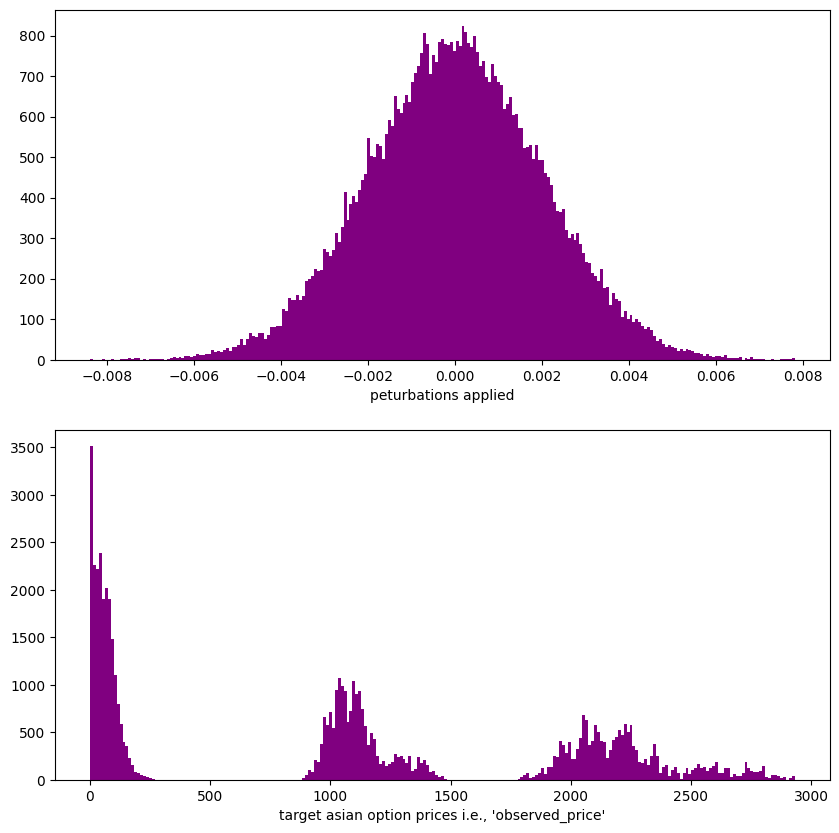

total data count: 57549
count   57549.00000
mean     1068.34485
std       909.08022
min         0.38760
25%        74.55829
50%      1064.12688
75%      2040.48583
max      2931.60279
Name: observed_price, dtype: float64


In [4]:
data = data[data[pricename]<=data['spot_price']]
data = data[data[pricename]>=0.01].copy()
data['observed_price'] = data[pricename]+np.random.normal(scale=0.002,size=data.shape[0])
data = data[data['observed_price']>=data['spot_price']*0.0001].copy()
p = data[pricename]-data['observed_price']
plotprices = data['observed_price']

fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].hist(p,bins=int(len(p)**0.5),color='purple')
axs[0].set_xlabel('peturbations applied')
axs[1].hist(plotprices,bins=int(len(plotprices)**0.5),color='purple')
axs[1].set_xlabel(f"target {pricename[:pricename.find('_')]} option prices i.e., 'observed_price'")
plt.show()
print(f"total data count: {data.shape[0]}")
print(data['observed_price'].describe())

# training procedure

In [5]:
from convsklearn import convsklearn
trainer = convsklearn()
help(trainer)
print('instance variables:')
trainer.__dict__

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object

instance va

{'seed': 1312,
 'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'observed_price',
 'excluded_features': ['barrier_price',
  'asian',
  'observed_price',
  'outin',
  'updown',
  'n_fixings'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [6]:
trainer.raw_data

""


In [7]:
trainer.load_data(data)
trainer.__dict__
trainer.dataset

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price,observed_price
0,4122.00000,2061.00000,7,1.00000,7,0,geometric,call,0.00061,0.01407,2021-04-12 16:00:15.864,0.00000,0.08240,-0.89361,0.48136,0.04407,2021-04-12,2060.08073,2060.07842
2,4122.00000,2061.00000,7,1.00000,7,0,arithmetic,call,0.00061,0.01407,2021-04-12 16:00:15.864,0.00000,0.08240,-0.89361,0.48136,0.04407,2021-04-12,2060.36257,2060.36563
4,4122.00000,3091.50000,7,1.00000,7,0,geometric,call,0.00061,0.01407,2021-04-12 16:00:15.864,0.00000,0.08240,-0.89361,0.48136,0.04407,2021-04-12,1029.59277,1029.59247
6,4122.00000,3091.50000,7,1.00000,7,0,arithmetic,call,0.00061,0.01407,2021-04-12 16:00:15.864,0.00000,0.08240,-0.89361,0.48136,0.04407,2021-04-12,1029.87461,1029.87422
8,4122.00000,4122.00000,7,1.00000,7,0,geometric,call,0.00061,0.01407,2021-04-12 16:00:15.864,0.00000,0.08240,-0.89361,0.48136,0.04407,2021-04-12,30.00567,30.00752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89991,5857.00000,5856.50000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,176.72445,176.72646
89993,5857.00000,7320.75000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1437.72795,1437.72630
89995,5857.00000,7320.75000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1429.79509,1429.79583
89997,5857.00000,8785.00000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,2887.93407,2887.93203


## preprocessing

In [8]:
dates = pd.Series(np.sort(data['date'].unique()))
dates

0      2021-04-12
1      2021-04-14
2      2021-04-19
3      2021-04-20
4      2021-04-22
          ...    
369    2024-09-24
370    2024-10-07
371    2024-10-08
372    2024-10-09
373    2024-10-14
Length: 374, dtype: object

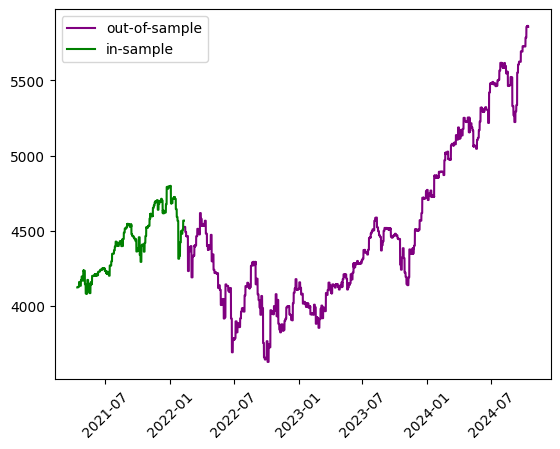

In [9]:
development_dates = dates[:len(dates)//4]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [10]:
trainer.run_dnn()


training on 14933 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
random_state: 1312
cpu: 2.2561872005462646


In [11]:
print('instance varianbles:')
trainer.__dict__

instance varianbles:


{'seed': 1312,
 'raw_data':        spot_price  strike_price  days_to_maturity  n_fixings  \
 0      4122.00000    2061.00000                 7    1.00000   
 2      4122.00000    2061.00000                 7    1.00000   
 4      4122.00000    3091.50000                 7    1.00000   
 6      4122.00000    3091.50000                 7    1.00000   
 8      4122.00000    4122.00000                 7    1.00000   
 ...           ...           ...               ...        ...   
 89991  5857.00000    5856.50000                84    1.00000   
 89993  5857.00000    7320.75000                84    1.00000   
 89995  5857.00000    7320.75000                84    1.00000   
 89997  5857.00000    8785.00000                84    1.00000   
 89999  5857.00000    8785.00000                84    1.00000   
 
        fixing_frequency  past_fixings averaging_type     w  risk_free_rate  \
 0                     7             0      geometric  call         0.00061   
 2                     7         

In [12]:
trainer.model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'fixing_frequency',
                                                                                        'past_fixings',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'asian_price']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['averaging_type',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(15,
                                                                                       15),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   random_state=1312,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())

### initial test

In [13]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 6.987975427257891
     MAE: 4.502981268695634

out of sample:
     RMSE: 118.19046702682508
     MAE: 82.43371543175155


In [14]:
oserr = trainer.test_data['outofsample_error']
iserr = trainer.train_data['insample_error']

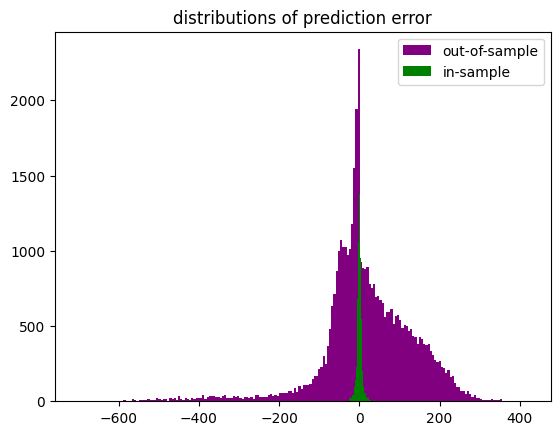

In [15]:
plt.figure()
plt.hist(oserr,color='purple',label='out-of-sample',bins=int(np.sqrt(len(oserr))))
plt.hist(iserr,color='green',label='in-sample',bins=int(np.sqrt(len(iserr))))
plt.legend()
plt.title('distributions of prediction error')
plt.show()

## saving

In [16]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_08 145533514650 cboe spx asian

cpu: 4.758107423782349


In [17]:
trainer.model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'fixing_frequency',
                                                                                        'past_fixings',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'asian_price']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['averaging_type',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(15,
                                                                                       15),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   random_state=1312,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())